# 実践コンピュータビジョン
# 4章 画像間の写像
## 4.3 平面とマーカーを使った姿勢推定
テキストp.88

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
from scipy import linalg

In [3]:
import homography
import camera
import sift

In [4]:
# 特徴量を計算する
fpath = 'images/zemikadai1130'
sift.process_image(fpath + '.jpeg', fpath + '.sift')
l0,d0 = sift.read_features_from_file(fpath + '.sift')

fpath =  'images/zemikadai1130_2'
sift.process_image(fpath + '.jpeg', fpath + '.sift')
l1,d1 = sift.read_features_from_file(fpath + '.sift')

sh: sift: command not found


processed tmp.pgm to images/zemikadai1130.sift


sh: sift: command not found


processed tmp.pgm to images/zemikadai1130_2.sift


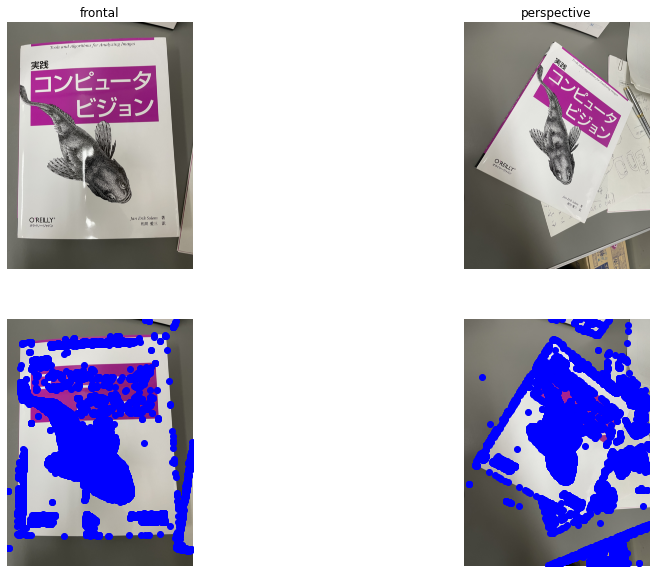

In [5]:
# 2つの画像を表示する
imname0 = 'images/zemikadai1130.jpeg'
imname1 =  'images/zemikadai1130_2.jpeg'

im0 = np.array(Image.open(imname0)) 
im1 = np.array(Image.open(imname1)) 

plt.figure(figsize=(15,10))
imlist = [im0, im1]
tlist = ['frontal', 'perspective']
loclist = [l0, l1]

# display the original images
for i, im, t, loc in zip(range(2), imlist, tlist, loclist):
    plt.subplot(2,2,i+1)
    plt.imshow(im)
    plt.title(t)
    plt.axis('off')

# plot SIFT points
for i, im, t, loc in zip(range(2), imlist, tlist, loclist):
    plt.subplot(2,2,i+3)
    sift.plot_features(im, loc)

plt.show()

In [6]:
im0.shape

(4032, 3024, 3)

### 画像の変換を推定する
2枚の画像のSIFT特徴量を対応づけて、左側の画像（frontal）から右側の画像（perspective）に変換する行列を推定する。

In [7]:
# 開始側の画像im0のサイズ
im0.shape

(4032, 3024, 3)

In [8]:
# 移動側の画像im1のサイズ
im1.shape

(4032, 3024, 3)

In [9]:
# 特徴点を対応づけてホモグラフィーを推定する
matches = sift.match_twosided(d0, d1)
matches.shape

(46959,)

matchesの非ゼロのインデックスを抽出する

> ndx = matches.nonzero()

とすると、出力がtupleになってしまうため、
[0]をつけて、numpy.arrayになるようにする

In [10]:
# 参考のための出力
tmp = matches.nonzero()
print(type(tmp))

<class 'tuple'>


In [11]:
# numpy.array型になるようインデックスを出力する
ndx = matches.nonzero()[0]
print(ndx[:10])
print(type(ndx))

[203 258 259 299 384 409 495 550 559 596]
<class 'numpy.ndarray'>


In [12]:
# 開始点（d0）から対応点（d1）のインデックスの対応関係
matches[ndx[:10]]

array([1084, 1992, 2426, 2108, 1265, 2052, 1348, 2927, 2100, 2049])

### 同次座標の行列の生成
homographyモジュール内のmake_homog()関数で、点群データに対する同次座標を生成する。<br>

```python
def make_homog(points):
    """ Convert a set of points (dim*n array) to 
        homogeneous coordinates. """
        
    return vstack((points,ones((1,points.shape[1])))) 
```

In [13]:
# 開始側の点群の同次座標の行列を作る
fp = homography.make_homog(l0[ndx, :2].T)
# fp[0]: X座標、fp[1]: Y座標、fp[2]: 1
fp[:,:5]

array([[2.31926086e+02, 2.39280228e+02, 2.39552399e+02, 2.41939194e+02,
        2.50273270e+02],
       [1.29863062e+03, 1.13912683e+03, 1.07327808e+03, 1.12970239e+03,
        1.28108765e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00]])

In [14]:
# 対応点（d1）のインデックスの対応関係
ndx2 = [int(matches[i]) for i in ndx]
# 移動した先の対応点の点群
tp = homography.make_homog(l1[ndx2,:2].T)
# tp[0]: X座標、tp[1]: Y座標、tp[2]: 1
tp[:,:5]

array([[1.16747009e+03, 1.23331946e+03, 1.25325952e+03, 1.23887317e+03,
        1.18975696e+03],
       [8.81370728e+02, 7.92221069e+02, 7.50690613e+02, 7.86626953e+02,
        8.87165894e+02],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00]])

In [15]:
# RANSACモデルの生成とフィッティング
model = homography.RansacModel()
H = homography.H_from_ransac(fp, tp, model)[0]
H

array([[ 7.54811217e-01, -3.90376419e-01,  1.49128581e+03],
       [ 5.99649514e-01,  6.02293258e-01, -3.55993346e+01],
       [ 8.89392602e-05, -2.73952746e-05,  1.00000000e+00]])

In [16]:
# カメラのキャリブレーションを行う
def my_calibration(sz):
    row,col = sz
    fx = 2555.0*col/2592
    fy = 2586.0*row/1936
    K = np.diag([fx,fy,1])
    K[0,2] = 0.5*col
    K[1,2] = 0.5*row
    return K

In [17]:
# 立方体を描画するための関数
def cube_points(c,wid):
    """plotで立方体を描画するための頂点のリストを生成する。
     最初の5点は底面の正方形であり、辺が繰り返されます """
    p = []
    # 底面
    p.append([c[0]-wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]-wid,c[2]-wid]) # 描画を閉じるため第一点と同じ

    # 上面
    p.append([c[0]-wid,c[1]-wid,c[2]+wid]) 
    p.append([c[0]-wid,c[1]+wid,c[2]+wid]) 
    p.append([c[0]+wid,c[1]+wid,c[2]+wid]) 
    p.append([c[0]+wid,c[1]-wid,c[2]+wid]) 
    p.append([c[0]-wid,c[1]-wid,c[2]+wid]) # 描画を閉じるため第一点と同じ

    # 垂直の辺
    p.append([c[0]-wid,c[1]-wid,c[2]+wid]) 
    p.append([c[0]-wid,c[1]+wid,c[2]+wid]) 
    p.append([c[0]-wid,c[1]+wid,c[2]-wid]) 
    p.append([c[0]+wid,c[1]+wid,c[2]-wid]) 
    p.append([c[0]+wid,c[1]+wid,c[2]+wid]) 
    p.append([c[0]+wid,c[1]-wid,c[2]+wid]) 
    p.append([c[0]+wid,c[1]-wid,c[2]-wid]) 
    return np.array(p).T

In [18]:
# カメラのキャリブレーション
# 画像のサイズ縦、横を引数とする
K = my_calibration((im0.shape[0],im0.shape[1])) 
K

array([[2.98083333e+03, 0.00000000e+00, 1.51200000e+03],
       [0.00000000e+00, 5.38571901e+03, 2.01600000e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [19]:
# z=0の平面上の辺の長さ0.2の立方体の3Dの点
# cube_points()で計算した１７点のXYZ座標
box = cube_points([0,0,0.1],0.1) 
box.shape

(3, 17)

In [20]:
box

array([[-0.1, -0.1,  0.1,  0.1, -0.1, -0.1, -0.1,  0.1,  0.1, -0.1, -0.1,
        -0.1, -0.1,  0.1,  0.1,  0.1,  0.1],
       [-0.1,  0.1,  0.1, -0.1, -0.1, -0.1,  0.1,  0.1, -0.1, -0.1, -0.1,
         0.1,  0.1,  0.1,  0.1, -0.1, -0.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
         0.2,  0. ,  0. ,  0.2,  0.2,  0. ]])

In [21]:
# 第1の画像の底面の正方形を射影する
cam1 = camera.Camera(np.hstack((K,np.dot(K,np.array([[0],[0],[-1]])) )) ) 
cam1.P

array([[ 2.98083333e+03,  0.00000000e+00,  1.51200000e+03,
        -1.51200000e+03],
       [ 0.00000000e+00,  5.38571901e+03,  2.01600000e+03,
        -2.01600000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -1.00000000e+00]])

In [22]:
# 最初の点群は、底面の正方形
box_cam1 = cam1.project(homography.make_homog(box[:,:5])) 
box_cam1

array([[1.81008333e+03, 1.81008333e+03, 1.21391667e+03, 1.21391667e+03,
        1.81008333e+03],
       [2.55457190e+03, 1.47742810e+03, 1.47742810e+03, 2.55457190e+03,
        2.55457190e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00]])

In [23]:
# Hを使って第2の画像に点を変換する
box_trans = homography.normalize(np.dot(H,box_cam1)) 
box_trans

array([[1.70513758e+03, 2.03549988e+03, 1.71506067e+03, 1.35871294e+03,
        1.70513758e+03],
       [2.37250921e+03, 1.73104763e+03, 1.48214010e+03, 2.14929294e+03,
        2.37250921e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00]])

In [24]:
# cam1とHから第2のカメラ行列を計算する
cam2 = camera.Camera(np.dot(H, cam1.P)) 
cam2.P

array([[ 2.24996644e+03, -2.10245770e+03,  1.84556151e+03,
        -1.84556151e+03],
       [ 1.78745526e+03,  3.24378225e+03,  2.08529394e+03,
        -2.08529394e+03],
       [ 2.65113111e-01, -1.47543251e-01,  1.07924729e+00,
        -1.07924729e+00]])

In [25]:
A = np.dot(np.linalg.inv(K), cam2.P[:,:3]) 
A = np.array([A[:,0],A[:,1], np.cross(A[:,0],A[:,1])]).T 
cam2.P[:,:3] = np.dot(K,A) 

In [26]:
# 第2のカメラ行列を使って射影する
box_cam2 = cam2.project(homography.make_homog(box))

In [27]:
# テスト：z=0上の点を射影を変換すると同じになるはず
point = np.array([1,1,0,1]).T 
print(homography.normalize(np.dot(np.dot(H,cam1.P),point)) )
print(cam2.project(point))

[-1.69805277e+03  2.94594357e+03 -9.61677428e-01]
[ 1.76571969e+03 -3.06333858e+03  1.00000000e+00]


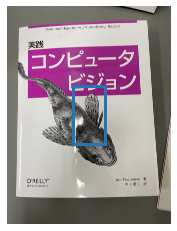

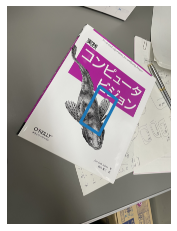

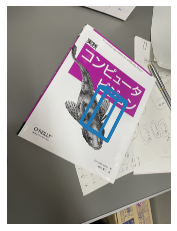

In [28]:
im0 = np.array(Image.open('images/zemikadai1130.jpeg'))
im1 = np.array(Image.open('images/zemikadai1130_2.jpeg'))

# 底面の正方形を2Dに射影
plt.figure() 
plt.imshow(im0) 
plt.plot(box_cam1[0,:],box_cam1[1,:],linewidth=3)
plt.axis('off')

# Hで変換されたものを2Dに射影
plt.figure() 
plt.imshow(im1)
plt.plot(box_trans[0,:],box_trans[1,:],linewidth=3)
plt.axis('off')

# 3Dの立方体
plt.figure() 
plt.imshow(im1)
plt.plot(box_cam2[0,:],box_cam2[1,:],linewidth=3)
plt.axis('off')

plt.show()

In [29]:
import pickle

with open('ar_camera.pkl','wb') as f:
    pickle.dump(K,f)
    pickle.dump(np.dot(np.linalg.inv(K),cam2.P),f)